In [1]:
import os

import fitsio
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.table import Table, hstack, vstack
from astropy.coordinates import SkyCoord
from pandas import read_csv

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/anaconda3/envs/py35/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['vstack', 'hstack']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Read the Open Supernova Catalog

In [2]:
osc = read_csv('osc.csv')
nosc = len(osc)
print('Read {} supernovae in OSC catalog.'.format(nosc))

Read 41133 supernovae in OSC catalog.


In [3]:
osc

,Name,Disc. Date,mmax,Host Name,R.A.,Dec.,z,Type,Phot.,Spec.,Radio,X-ray
0,SN1987A,1987/02/24,1.90,LMC,"05:35:28.020,05:35:28,05:35:28.01,05:35:27.99","-69:16:11.07,-69:16:11,-69:16:11.61,-69:16:11....","9.51e-06,9.78e-06,1.02e-05,1.06e-05,1.07e-05,1...",II Pec,3332.0,36.0,NaN,105.0
1,SN2003dh,2003/03/31,12.62,A104450+2131,"10:44:50.030,10:44:50.01,10:44:50.018","+21:31:18.15,+21:31:17.8,+21:31:17.80,+21:31:1...",0.1685,Ic BL,2781.0,13.0,NaN,NaN
2,SN2011fe,2011/08/24,9.48,NGC 5457,"14:03:05.711,14:03:05.76,14:03:05.81,14:03:05.80","+54:16:25.22,+54:16:25.32,+54:16:25.4,+54:16:2...",0.000804,Ia,2728.0,80.0,0.0,0.0
3,SN1993J,1993/03/28,9.91,NGC 3031,"09:55:24.7747,09:55:24.95,09:55:25.00","+69:01:13.702,+69:01:13.38,+69:01:13.01,+69:01...",-0.000113,IIb,1814.0,50.0,NaN,NaN
4,SN2002ap,2002/01/29,12.04,NGC 628,"01:36:23.85,01:36:23.87","+15:45:13.2,+15:45:13.21,+15:45:13.0",0.002108,Ic BL,1781.0,39.0,NaN,NaN
5,SN2009ip,2012/07/24,12.01,NGC 7259,"22:23:08.3,22:23:08.26","-28:56:52,-28:56:52.4,-28:56:52.40",0.005944,LBV to IIn,1569.0,240.0,NaN,NaN
6,SN2011dh,2011/06/01,12.06,NGC 5194,"13:30:05.1055,13:30:05.12,13:30:05.124","+47:10:10.922,+47:10:11.3,+47:10:10.81,+47:10:...",0.001638,IIb,1333.0,71.0,NaN,NaN
7,SN2000cx,2000/07/17,12.90,NGC 524,"01:24:46.19,01:24:46.15","+09:30:31.3,+09:30:30.9,+09:30:30.89","0.007929,0.008076",Ia Pec,1316.0,45.0,NaN,NaN
8,SN1999em,1999/10/29,12.80,NGC 1637,"04:41:27.04,04:41:27.168,04:41:27.13,04:41:27.05","-02:51:45.2,-02:51:45.828,-02:51:45.4,-02:51:4...",0.002392,II P,1207.0,72.0,NaN,NaN
9,SN1999ee,1999/10/07,14.50,IC 5179,"22:16:09.40,22:16:10.00","-36:50:31.5,-36:50:39.7,-36:50:39.70","0.01141,0.01141",Ia,1169.0,26.0,NaN,NaN


Since we're going to be matching against the SDSS database, we probably only want objects whose host galaxy name is populated (maybe)?

In [4]:
keep = np.where(['nan' not in str(hostname).lower() for hostname in osc['Host Name']])[0]
nosc = len(keep)
print('Keeping {} OSC supernovae with known host galaxies.'.format(nosc))
osc = osc.loc[keep]
osc = osc.reset_index(drop=True)

Keeping 16838 OSC supernovae with known host galaxies.


### Loop on each supernova and get the mean coordinates.

In [5]:
def _hms(ra):
    """Convert RA in hms to decimal degrees."""
    sep1 = ra.find(':')
    hh = int( ra[0:sep1] )
    sep2 = ra[sep1+1:].find(':')
    if sep2 == -1:
        mm = float( ra[sep1+1:] )
        ss = 0.0
    else:
        mm = int( ra[sep1+1:sep1+sep2+1] )
        ss = float( ra[sep1+sep2+2:] )
    return hh*15.0 + mm/4.0 + ss/240.0

In [6]:
def _dms(dec):
    """Convert Dec in dms to decimal degrees."""
    Csign = dec[0]
    if Csign == '-':
        sign = -1.0
        off = 1
    elif Csign == '+':
        sign = 1.0
        off = 1
    else:
        sign = 1.0
        off = 0
    sep1 = dec.find(':')
    deg = int( dec[off:sep1] )
    sep2 = dec[sep1+1:].find(':')
    if sep2 == -1:
        arcmin = float( dec[sep1+1:] )
        arcsec = 0.0
    else:
        arcmin = int( dec[sep1+1:sep1+sep2+1] )
        arcsec = float( dec[sep1+sep2+2:] )
    
    return sign * (deg + (arcmin*5.0/3.0 + arcsec*5.0/180.0) / 100.0)

In [7]:
ra, dec, good = np.zeros(nosc), np.zeros(nosc), np.ones(nosc)
for ii in range(nosc):
    sra = str(osc['R.A.'][ii]).split(',')
    sdec = str(osc['Dec.'][ii]).split(',')
    if 'nan' in sra:
        good[ii] = 0
        continue
    nn = len(sra)
    ra1 = np.zeros(nn)
    dec1 = np.zeros(nn)
    for jj, (rr, dd) in enumerate(zip(sra, sdec)):
        #print(ii, rr, dd)
        if ':' in rr:
            ra1[jj] = _hms(rr)
            dec1[jj] = _dms(dd)
        else:
            ra1[jj] = rr
            dec1[jj] = dd
    ra[ii] = np.mean(ra1)
    dec[ii] = np.mean(dec1)

In [8]:
indx = np.where(good)[0]
oscgood = osc.loc[indx]
oscra, oscdec = ra[indx], dec[indx]
noscgood = len(oscgood)
print('Found {} OSC supernovae with good coordinates.'.format(noscgood))

Found 16823 OSC supernovae with good coordinates.


For reference, here are the SNe with bad or no coordinates.

In [9]:
osc.loc[np.where(good == 0)[0]]

,Name,Disc. Date,mmax,Host Name,R.A.,Dec.,z,Type,Phot.,Spec.,Radio,X-ray
973,SNLS-04D4fu,2004/10/19,21.57,APMUKS(BJ) B221128.89-174722.6,NaN,NaN,"0.133,0.133,0.144",NaN,55.0,NaN,NaN,NaN
1475,SNLS-04D1pj,2004/12/13,21.43,XMDS J022649.3-041154,NaN,NaN,"0.1556,0.1556",NaN,38.0,NaN,NaN,NaN
3350,SNLS-03D4cw,2003/08/27,22.11,APMUKS(BJ) B221331.31-172920.9,NaN,NaN,"0.1543,0.1543",NaN,18.0,NaN,NaN,NaN
14740,PS10r,2010,NaN,SDSS J104438.19+574839.8,NaN,NaN,0.1188,NaN,NaN,NaN,NaN,NaN
14741,PS10v,2010,NaN,SDSS J100325.83+010143.3,NaN,NaN,0.0996,NaN,NaN,NaN,NaN,NaN
14742,PS10z,2010,NaN,PS1 J083612.60+440025.5,NaN,NaN,0.1406,NaN,NaN,NaN,NaN,NaN
16787,SDSS-II SN 10030,NaN,NaN,2MASX J01154483+0014005,NaN,NaN,0.044337,NaN,NaN,NaN,NaN,NaN
16788,SDSS-II SN 10121,NaN,NaN,NGC 7398,NaN,NaN,0.015718,NaN,NaN,NaN,NaN,NaN
16789,SDSS-II SN 14386,NaN,NaN,MCG +00-04-045,NaN,NaN,0.044344,NaN,NaN,NaN,NaN,NaN
16790,SDSS-II SN 15199,NaN,NaN,SDSS J205236.96-002715.0,NaN,NaN,0.4199,NaN,NaN,NaN,NaN,NaN


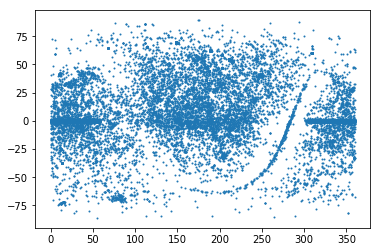

In [10]:
fig, ax = plt.subplots()
ax.scatter(oscra, oscdec, s=1)

### Read the SDSS galspecinfo catalog and match.

In [11]:
ff = fitsio.FITS('galSpecInfo-dr8.fits')
ff[1]


  file: galSpecInfo-dr8.fits
  extension: 1
  type: BINARY_TBL
  rows: 1843200
  column info:
    SPECOBJID          S19  
    RELIABLE            i2  
    PLATEID             i2  
    MJD                 i4  
    FIBERID             i2  
    PHOTOID             i2  array[5]
    RA                  f4  
    DEC                 f4  
    PLUG_MAG            f4  array[5]
    PRIMTARGET          i2  
    SECTARGET           i2  
    TARGETTYPE         S19  
    SPECTROTYPE         S6  
    SUBCLASS           S21  
    Z                   f4  
    Z_ERR               f4  
    Z_WARNING           i2  
    V_DISP              f4  
    V_DISP_ERR          f4  
    SN_MEDIAN           f4  
    E_BV_SFD            f4  
    ZTWEAK              f4  
    ZTWEAK_ERR          f4  
    SPECTRO_MAG         f4  array[3]
    KCOR_MAG            f4  array[3]
    KCOR_MODEL_MAG      f4  array[5]
    RELEASE            S12  

A handful of RA, Dec coordinates are -9999, so don't read those rows.

In [12]:
#sdssgood = ff[1].where("RA >= 0.0 && RA <= 360.0 && Z_WARNING == 0 && SPECTROTYPE == 'GALAXY'")
sdssgood = ff[1].where("RA >= 0.0 && RA <= 360.0 && RELIABLE == 1")
cols = ['SPECOBJID', 'RA', 'DEC', 'PLATEID', 'MJD', 'FIBERID', 'Z']
sdss = Table(ff[1].read(rows=sdssgood, upper=True, columns=cols))
print('Read {} SDSS galaxies with good redshifts and coordinates.'.format(len(sdss)))

Read 926066 SDSS galaxies with good redshifts and coordinates.


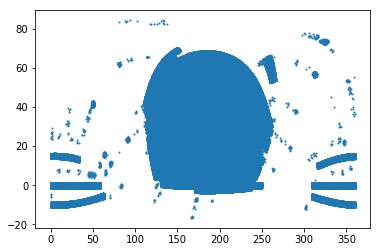

In [13]:
fig, ax = plt.subplots()
ax.scatter(sdss['RA'], sdss['DEC'], s=1)

In [14]:
scoord = SkyCoord(ra=sdss['RA']*u.degree, dec=sdss['DEC']*u.degree)
ocoord = SkyCoord(ra=oscra*u.degree, dec=oscdec*u.degree)
idx, sep2d, _ = scoord.match_to_catalog_sky(ocoord)

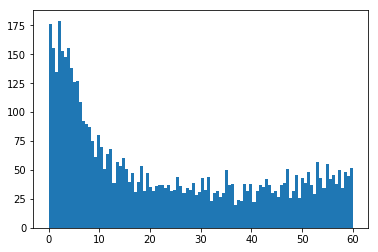

In [15]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(sep2d.to(u.arcsec).value, bins=100, range=(0, 60))

### Examine the matches within 10 arcsec, but this isn't quite right.  We should really take into account the size of the host galaxy and a myriad other issues.

In [16]:
rad = 10.0 * u.arcsec
sdssmatch = np.where(sep2d < rad)[0]
oscmatch = idx[sdssmatch]
nmatch = len(sdssmatch)
print('Found {} matches within {}'.format(nmatch, rad))

Found 2057 matches within 10.0 arcsec


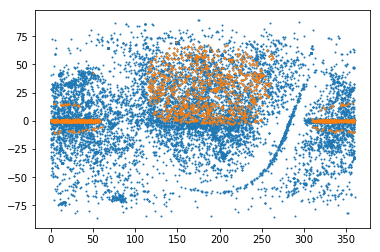

In [17]:
fig, ax = plt.subplots()
ax.scatter(oscra, oscdec, s=1)
#ax.scatter(oscra[oscmatch], oscdec[oscmatch], s=1)
ax.scatter(sdss['RA'][sdssmatch], sdss['DEC'][sdssmatch], s=1)

### Write out the matched catalogs.

In [18]:
oscout = oscgood.loc[oscmatch]
oscout

,Name,Disc. Date,mmax,Host Name,R.A.,Dec.,z,Type,Phot.,Spec.,Radio,X-ray
7091,PS17bwi,2017/03/17,20.200,CGCG 190-014,"13:29:36.28,13:29:36.270,13:29:36.27","+34:36:00.20,+34:36:00.2",0.032589,NaN,6.0,NaN,NaN,NaN
7091,PS17bwi,2017/03/17,20.200,CGCG 190-014,"13:29:36.28,13:29:36.270,13:29:36.27","+34:36:00.20,+34:36:00.2",0.032589,NaN,6.0,NaN,NaN,NaN
10266,SN2001km,2001/02/15,18.400,A091138-0042,"09:11:38.38,09:11:38.4,09:11:38.00","-00:42:54.0,-00:42:54,-00:42:09.00","0.07022,0.07",Ia,1.0,NaN,NaN,NaN
10268,SN2001ko,2001/03/16,20.000,A141058+6450,"14:10:58.330,14:10:58.32,14:10:58.00","+64:50:50.90,+64:50:51,+64:50:08.02,+64:50:50.9","0.1406,0.14,0.1406",Ia,1.0,NaN,NaN,NaN
2568,SN2013cg,2013/05/06,13.300,NGC 2891,09:26:56.77,"-24:46:59.6,-24:46:59.59",0.007952,Ia,24.0,3.0,NaN,NaN
3715,PS17dbo,2017/05/15,18.920,2MASX J17150091+7729413,"17:15:00.81,17:15:00.810,17:15:00.80","+77:29:44.46,+77:29:44.4",NaN,NaN,17.0,NaN,NaN,NaN
10100,SN2000fs,2000/09/06,18.700,NGC 1218,"03:08:26.23,03:08:26.24","+04:06:39.0,+04:06:39.9,+04:06:39.89",0.029,Ia,1.0,NaN,NaN,NaN
8109,PS1-14afw,2014/12/18,19.270,APMUKS(BJ) B235342.55-070747.0,23:56:16.34,-06:51:04.4,NaN,NaN,4.0,NaN,NaN,NaN
5112,PS15dcd,2015/12/03,19.080,2MASX J01092115+1039563,01:09:21.20,+10:39:54.8,NaN,NaN,11.0,NaN,NaN,NaN
9995,SN1999M,1999/01/13,23.400,A100546-0727,10:05:46.60,"-07:27:31.3,-07:27:31.28","0.5,0.5",Ia,1.0,2.0,NaN,NaN


In [19]:
cols = ['LGM_TOT_P50', 'OH_P50', 'SFR_TOT_P50', 'SPECSFR_TOT_P50', 'BPTCLASS']
sdssout = Table(fitsio.read('galSpecExtra-dr8.fits', ext=1, rows=sdssmatch, columns=cols))
sdssout.add_columns(sdss[sdssmatch].columns.values())
sdssout

BPTCLASS,LGM_TOT_P50,OH_P50,SFR_TOT_P50,SPECSFR_TOT_P50,SPECOBJID,PLATEID,MJD,FIBERID,RA,DEC,Z
int16,float32,float32,float32,float32,bytes19,int16,int32,int16,float32,float32,float32
-1,10.8778,-9999.0,-0.942381,-11.8881,299634812510038016,266,51602,529,146.353,1.06037,0.127659
2,10.6931,-9999.0,-1.06421,-11.7894,299633163712358400,266,51630,523,146.353,1.06037,0.127619
4,10.6178,-9999.0,0.374983,-10.2892,300740371552430080,267,51608,455,147.971,1.10164,0.0632417
-1,10.8798,-9999.0,-1.17201,-12.1054,301898432593815552,268,51633,572,149.816,0.967329,0.0880019
5,10.9685,-9999.0,-1.36216,-12.3967,301905029663582208,268,51633,596,150.299,0.329321,0.0344885
0,0.0,0.0,0.0,0.0,305133474874943488,271,51883,53,154.893,-1.00934,0.0432955
-1,10.6372,-9999.0,-1.24343,-11.9343,305165910467962880,271,51883,171,154.502,-0.0327748,0.0650882
-1,11.3544,-9999.0,-1.67856,-13.1069,305188175578425344,271,51883,252,153.665,-0.83091,0.0490197
5,10.4385,-9999.0,-0.774026,-11.2554,308582093598779392,274,51913,311,158.474,0.0765329,0.187105


In [20]:
sdssfile = 'galSpec-oscmatched.csv'
print('Writing {}'.format(sdssfile))
sdssout.write(sdssfile, format='csv', overwrite=True)

Writing galSpec-oscmatched.csv


In [21]:
oscfile = 'osc-galSpecmatched.csv'
print('Writing {}'.format(oscfile))
oscout.to_csv(oscfile)

Writing osc-galSpecmatched.csv
